In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import numpy as np
import makassar_ml as ml
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn themes.

In [3]:
def image_augmentation(image: tf.Tensor, size: tuple[int,int] = None):
    if size is not None:
        dtype = image.dtype # Preserve original data type for casting after resize operation.
        image = tf.image.resize(image, size=size)
        image = tf.cast(image, dtype)
    # image = keras.layers.experimental.preprocessing.Resizing(200,200)(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, dtype=tf.float32) / tf.constant(256, dtype=tf.float32) # Rescale.
    # image = tfa.image.rotate(image, tf.random.normal(shape=[])*np.pi/180., interpolation='bilinear')
    return image

In [4]:
# Load the dataset.
# image_shape = (72,72,3)
image_shape = (256,256,3)
(ds, info) = tfds.load(
    name='plant_village',
    split='train',
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)
label_names = info.features['label'].names

# Augment the training images.
ds = ds.map(lambda x, y: (image_augmentation(x, size=(image_shape[0],image_shape[1])), y))

In [57]:
import pandas as pd
from collections import defaultdict
d = defaultdict(list)
for _, y in ds:
    label_index = y.numpy()
    label_name = label_names[label_index]
    name, status = label_name.split('___')
    d['name'].append(name)
    d['status'].append(status)
pdf = pd.DataFrame(d)

In [74]:
print(pdf.groupby(['name','status']).size().to_latex(multirow=True))

\begin{tabular}{llr}
\toprule
       &         &     0 \\
name & status &       \\
\midrule
\multirow{4}{*}{Apple} & Apple\_scab &   630 \\
       & Black\_rot &   621 \\
       & Cedar\_apple\_rust &   275 \\
       & healthy &  1645 \\
\cline{1-3}
Blueberry & healthy &  1502 \\
\multirow{2}{*}{Cherry} & Powdery\_mildew &  1052 \\
       & healthy &   854 \\
\cline{1-3}
\multirow{4}{*}{Corn} & Cercospora\_leaf\_spot Gray\_leaf\_spot &   513 \\
       & Common\_rust &  1192 \\
       & Northern\_Leaf\_Blight &   985 \\
       & healthy &  1162 \\
\cline{1-3}
\multirow{4}{*}{Grape} & Black\_rot &  1180 \\
       & Esca\_(Black\_Measles) &  1383 \\
       & Leaf\_blight\_(Isariopsis\_Leaf\_Spot) &  1076 \\
       & healthy &   423 \\
\cline{1-3}
Orange & Haunglongbing\_(Citrus\_greening) &  5507 \\
\multirow{2}{*}{Peach} & Bacterial\_spot &  2297 \\
       & healthy &   360 \\
\cline{1-3}
\multirow{2}{*}{Pepper,\_bell} & Bacterial\_spot &   997 \\
       & healthy &  1477 \\
\cline{1-3}


/tmp/ipykernel_13180/314975679.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pdf.groupby(['name','status']).size().to_latex(multirow=True))


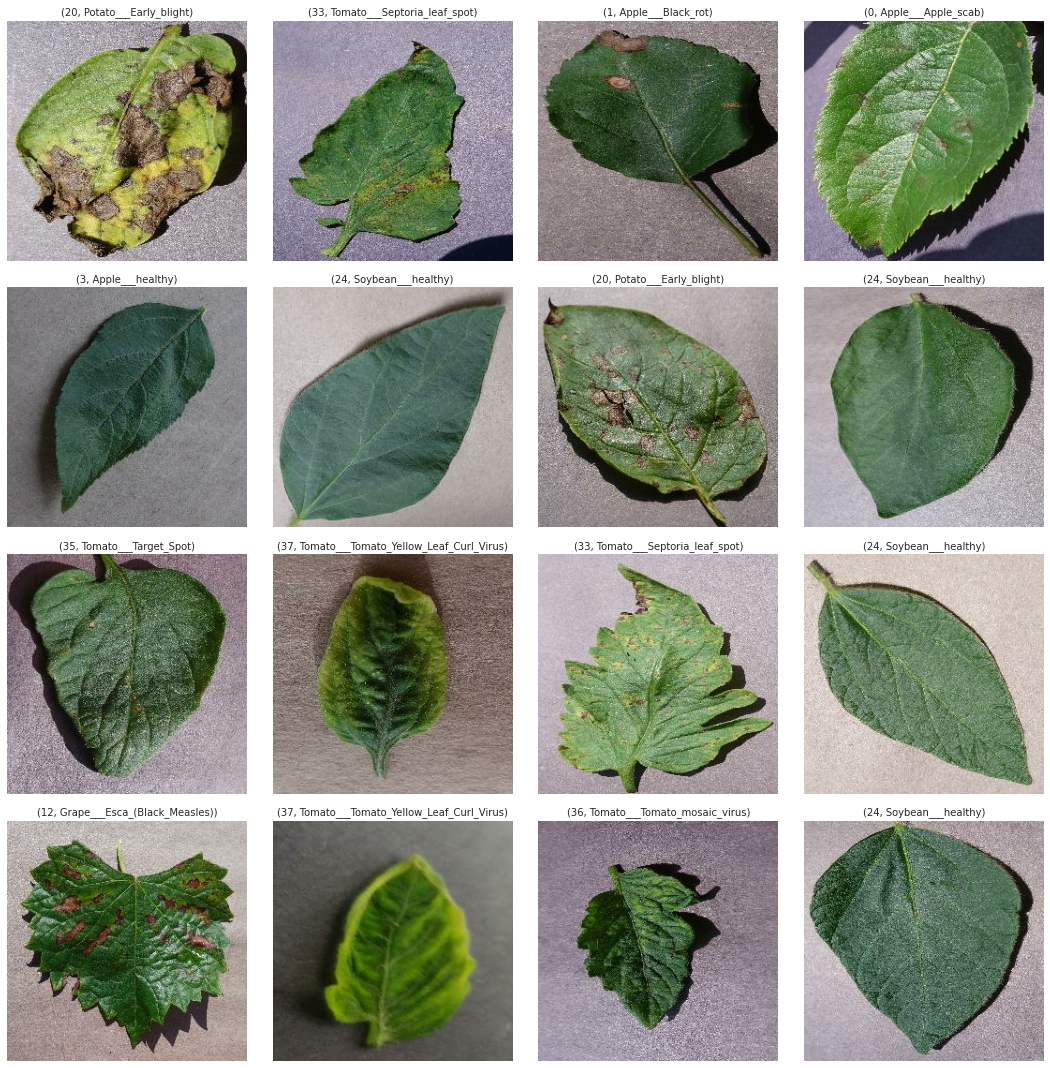

In [33]:
n = 16
fig = plt.figure(figsize=(15,15))
axes = fig.subplots(int(np.sqrt(n)), int(np.sqrt(n)), sharex=True)
axes = axes.flatten()
for example, ax in zip(ds.take(n), axes):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example[0]
    label = example[1].numpy()
    ax.set_title(f"({label}, {label_names[label]})", fontsize=10)
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
fig.tight_layout()

In [34]:
df = tfds.as_dataframe(ds, info)
df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 54303 entries, 0 to 54302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   54303 non-null  object
 1   label   54303 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 848.6+ KB


Text(0, 0.5, 'count')

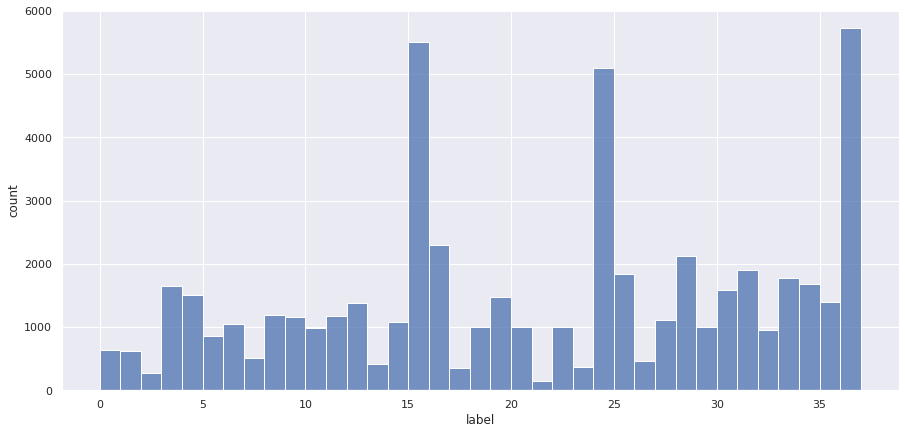

In [54]:
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(data=df, x='label', ax=ax, binwidth=1)
ax.set_ylabel('count')